#  First resnet implementation for kavisar -  PyTorch

In [80]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import confusion_matrix
import itertools


plt.ion()   # interactive mode



In [4]:
data_dir = 'data_v2'
model_dir = 'pytorch_models'
model_name = '7_1_resnet18_kavisar__2018_07_17_v2'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


#### Preparing test data

In [6]:
test_data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_data_transforms)

In [8]:
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=64, shuffle=False, num_workers=4)

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
def imshow(inp, title=None, size = [50,50]):
    """Imshow for Tensor."""
    plt.rcParams['figure.figsize'] = size # To resize images
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [14]:
plt.rcParams['figure.figsize'] = [100, 100]

In [16]:
class_names = image_datasets['train'].classes

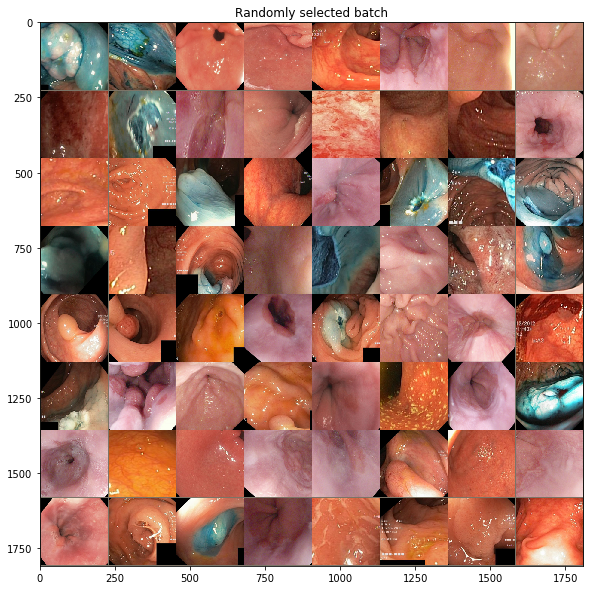

In [24]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='Randomly selected batch', size=[10,10])

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [39]:
def visualize_model(model, num_images=6, img_size=[10,10]):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], size=img_size)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [29]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.2324 Acc: 0.5663
validation Loss: 0.5715 Acc: 0.7919

Epoch 1/4
----------
train Loss: 0.5694 Acc: 0.7873
validation Loss: 0.3885 Acc: 0.8438

Epoch 2/4
----------
train Loss: 0.4503 Acc: 0.8260
validation Loss: 0.3321 Acc: 0.8700

Epoch 3/4
----------
train Loss: 0.4049 Acc: 0.8417
validation Loss: 0.2942 Acc: 0.8819

Epoch 4/4
----------
train Loss: 0.3694 Acc: 0.8575
validation Loss: 0.2741 Acc: 0.8900

Training complete in 2m 39s
Best val Acc: 0.890000


In [31]:
torch.save(model_ft.state_dict(), os.path.join(model_dir,model_name))

In [32]:
model_ft.load_state_dict(torch.load(os.path.join(model_dir,model_name)))

In [33]:
model_ft = model_ft.to(device)

In [37]:
plt.rcParams['figure.figsize'] = [5, 5]

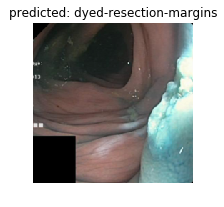

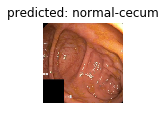

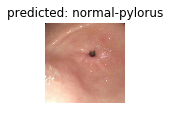

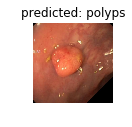

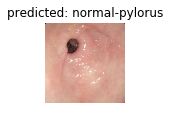

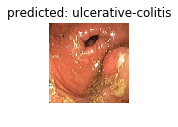

In [41]:
visualize_model(model_ft, img_size=[5,5])

## Testing the accuracy of the test data

In [50]:
model_ft.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        print((predicted == labels).sum())
        total += labels.size(0) 
        correct += (predicted == labels).sum()
        
print('Accuracy of the network on the %d test images: %d %%' % (total, (
    100 * correct / total)))   

tensor(53, device='cuda:0')
tensor(58, device='cuda:0')
tensor(53, device='cuda:0')
tensor(60, device='cuda:0')
tensor(64, device='cuda:0')
tensor(57, device='cuda:0')
tensor(54, device='cuda:0')
tensor(50, device='cuda:0')
tensor(52, device='cuda:0')
tensor(53, device='cuda:0')
tensor(58, device='cuda:0')
tensor(58, device='cuda:0')
tensor(58, device='cuda:0')
tensor(64, device='cuda:0')
tensor(64, device='cuda:0')
tensor(59, device='cuda:0')
tensor(52, device='cuda:0')
tensor(45, device='cuda:0')
tensor(54, device='cuda:0')
tensor(63, device='cuda:0')
tensor(61, device='cuda:0')
tensor(61, device='cuda:0')
tensor(60, device='cuda:0')
tensor(62, device='cuda:0')
tensor(58, device='cuda:0')
Accuracy of the network on the 1600 test images: 89 %


In [74]:
model_ft.eval()
correct = 0
total = 0
all_labels_d = torch.tensor([], dtype=torch.long).to(device)
all_predictions_d = torch.tensor([], dtype=torch.long).to(device)

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels_d = torch.cat((all_labels_d, labels),0)
        all_predictions_d = torch.cat((all_predictions_d, predicted),0)
       # all_labels_d.append(labels)
       # all_predictions_d.append(predicted)
        
testset_labels = all_labels_d.to('cpu')
testset_predicted_labels = all_predictions_d.to('cpu')

In [68]:
all_labels_d

tensor([ 0,  0,  0,  ...,  7,  7,  7], device='cuda:0')

In [73]:
all_predictions_d[200:300]

tensor([ 1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')

In [77]:
cm=confusion_matrix(testset_labels, testset_predicted_labels)

In [78]:
cm

array([[172,  23,   0,   0,   0,   0,   4,   1],
       [ 13, 187,   0,   0,   0,   0,   0,   0],
       [  0,   0, 159,   0,   0,  41,   0,   0],
       [  0,   0,   0, 179,   1,   0,  15,   5],
       [  1,   0,   0,   0, 199,   0,   0,   0],
       [  0,   0,  44,   0,   1, 155,   0,   0],
       [  1,   0,   0,   2,   2,   0, 193,   2],
       [  0,   0,   1,   5,   1,   0,   6, 187]])

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          plt_size=[10,10]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = plt_size
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[172  23   0   0   0   0   4   1]
 [ 13 187   0   0   0   0   0   0]
 [  0   0 159   0   0  41   0   0]
 [  0   0   0 179   1   0  15   5]
 [  1   0   0   0 199   0   0   0]
 [  0   0  44   0   1 155   0   0]
 [  1   0   0   2   2   0 193   2]
 [  0   0   1   5   1   0   6 187]]


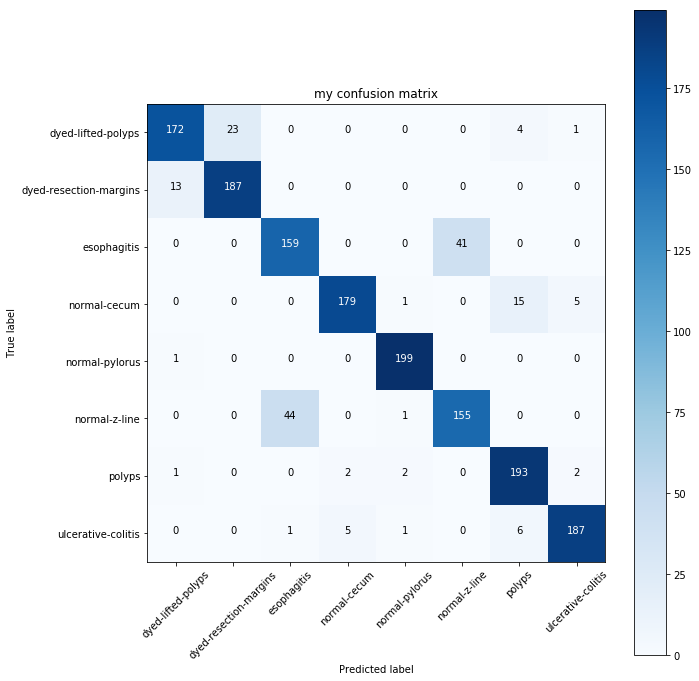

In [87]:
plot_confusion_matrix(cm, classes=class_names,title='my confusion matrix')

Normalized confusion matrix
[[0.86  0.115 0.    0.    0.    0.    0.02  0.005]
 [0.065 0.935 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.795 0.    0.    0.205 0.    0.   ]
 [0.    0.    0.    0.895 0.005 0.    0.075 0.025]
 [0.005 0.    0.    0.    0.995 0.    0.    0.   ]
 [0.    0.    0.22  0.    0.005 0.775 0.    0.   ]
 [0.005 0.    0.    0.01  0.01  0.    0.965 0.01 ]
 [0.    0.    0.005 0.025 0.005 0.    0.03  0.935]]


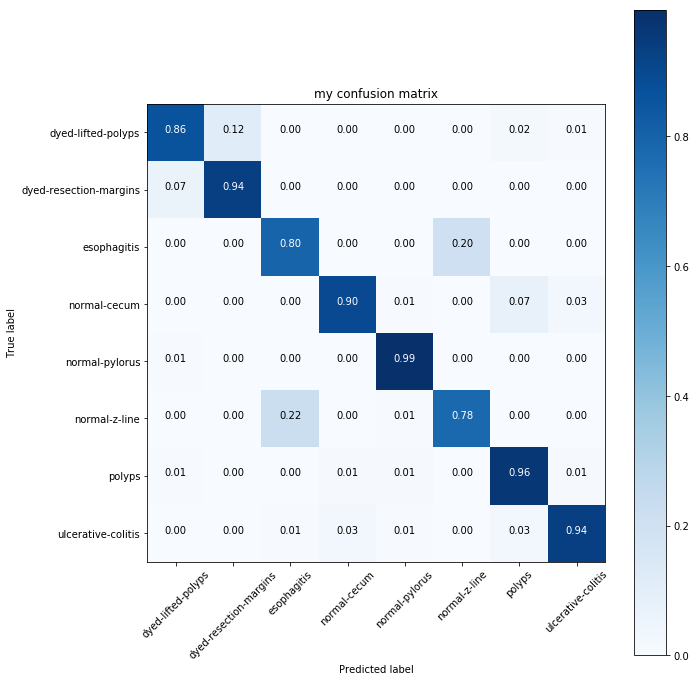

In [88]:
plot_confusion_matrix(cm, classes=class_names,title='my confusion matrix', normalize=True)

In [56]:
all_labels_d

[tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,

In [51]:
cm =0
with torch.no_grad():
    for data in test_dataloader:
        images_h, labels_h = data
        images_d = images_h.to(device)
        #labels_d = labels_h.to(device)
        output_d = model_ft(images_d)
        #output_h = output_d.to('cpu')
       # _, predicted = torch.max(output_d, 1)
        max_d, pred_d = torch.max(output_d, 1)
        pred_h = pred_d.to('cpu')
       # cm_d += confusion_matrix(labels_d, pred_d)
        cm += confusion_matrix(labels_h, pred_d)
    print(cm)

    

ValueError: operands could not be broadcast together with shapes (3,3) (4,4) (3,3) 

In [83]:
outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

IndentationError: unexpected indent (<ipython-input-83-f60d096d0369>, line 2)

In [57]:
cm = confusion_matrix(labels, preds)

In [58]:
cm

array([[ 5,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  8,  0,  0],
       [ 1,  0,  0,  0,  1,  0, 11,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  2]])